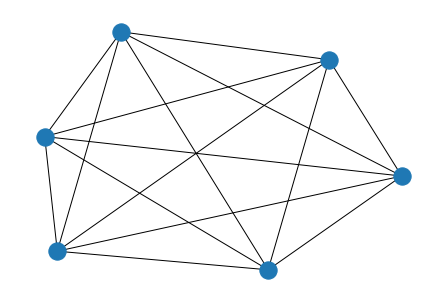

In [ ]:
# python -m graphsage.supervised_train --train_prefix ./example_data/toy-ppi --model graphsage_mean --sigmoid
# test networkx and visualization
import networkx as nx
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

G = nx.complete_graph(6)
nx.draw(G)

In [ ]:
# download code and data
!git clone https://github.com/williamleif/GraphSAGE

Cloning into 'GraphSAGE'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 265 (delta 3), reused 0 (delta 0), pack-reused 258
Receiving objects: 100% (265/265), 6.43 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [ ]:
import json
from networkx.readwrite import json_graph
import os
import numpy as np
import sys

CODE_ROOT = "GraphSAGE/graphsage"
sys.path.append("GraphSAGE")

def load_data():
    data_path = 'GraphSAGE/example_data'
    # DATA 1, 14755 nodes, 228431 links
    G_data = json.load(open(data_path + '/toy-ppi-G.json'))
    #G_data['nodes'] = G_data['nodes'][:100]
    #G_data['links'] = G_data['links'][:100]
    G = json_graph.node_link_graph(G_data)
    
    conversion = lambda n : n
    lab_conversion = lambda n : n
    
    # DATA 2, (14755, 50) dtype('float64')
    feats = np.load(data_path + '/toy-ppi-feats.npy')
    
    # DATA 3, {"0": 0, "1": 1}, len: 14755
    # node ids to integer values indexing feature tensor
    # 其实没什么用
    id_map = json.load(open(data_path + "/toy-ppi-id_map.json"))
    
    # DATA 4, dict, len: 14755, column 121
    # from node ids to class values (integer or list)
    # 分类标签
    class_map = json.load(open(data_path + "/toy-ppi-class_map.json"))
    
    broken_count = 0
    for node in G.nodes():
      if not 'val' in G.nodes()[node] or not 'test' in G.nodes()[node]:
        G.remove_node(node)
        broken_count += 1
    print("Removed {:d} nodes that lacked proper annotations due to networkx versioning issues".format(broken_count))
    
    # edge: (0, 800) 边
    # G[0]: 某结点与所有的关联结点组成的边的集合
    # 标记需要在训练中移除的关联关系，即边
    for edge in G.edges():
      if (G.nodes()[edge[0]]['val'] or G.nodes()[edge[1]]['val'] or
          G.nodes()[edge[0]]['test'] or G.nodes()[edge[1]]['test']):
        G[edge[0]][edge[1]]['train_removed'] = True
      else:
        G[edge[0]][edge[1]]['train_removed'] = False
    
    from sklearn.preprocessing import StandardScaler
    
    # 训练集的id集合，result only int, len: 9716
    train_ids = np.array([id_map[str(n)] for n in G.nodes() \
                          if not G.nodes()[n]['val'] and not G.nodes()[n]['test']])
    
    train_feats = feats[train_ids]
    
    # 特征缩放，标准化：z = (x - u) / s
    # u is the mean of the training samples
    # s is the standard deviation of the training samples
    scaler = StandardScaler()
    scaler.fit(train_feats)
    feats = scaler.transform(feats)

    walks = []

    return G, feats, id_map, walks, class_map

In [ ]:
def construct_placeholders(num_classes):
  # Define placeholders
  placeholders = {
      'labels' : tf.compat.v1.placeholder(tf.float32, shape=(None, num_classes), name='labels'),
      'dropout': tf.compat.v1.placeholder_with_default(0., shape=(), name='dropout'),
      'batch' : tf.compat.v1.placeholder(tf.int32, shape=(None), name='batch1'),
      'batch_size' : tf.compat.v1.placeholder(tf.int32, name='batch_size'),
  }
  return placeholders

In [ ]:
train_data = load_data()

Removed 0 nodes that lacked proper annotations due to networkx versioning issues


In [ ]:
G = train_data[0]
features = train_data[1]
id_map = train_data[2]
context_pairs = train_data[3]
class_map  = train_data[4]

# num_classes = 121
num_classes = len(list(class_map.values())[0])
# pad with dummy zero vector, row wise
features = np.vstack([features, np.zeros((features.shape[1],))])
placeholders = construct_placeholders(num_classes)

In [ ]:
class NodeMinibatchIterator(object):

    """
    This minibatch iterator iterates over nodes for supervised learning.

    G -- networkx graph
    id2idx -- dict mapping node ids to integer values indexing feature tensor
    placeholders -- standard tensorflow placeholders object for feeding
    label_map -- map from node ids to class values (integer or list)
    num_classes -- number of output classes
    batch_size -- size of the minibatches
    max_degree -- maximum size of the downsampled adjacency lists
    以toy-ppi数据集举例：
    label_map为输出，维度为(14755, 121)
    num_class为label_map的第二维，即121
    """
    def __init__(self, G, id2idx,
            placeholders, label_map, num_classes,
            batch_size=100, max_degree=25,
            **kwargs):

        self.G = G
        self.nodes = G.nodes()
        self.id2idx = id2idx
        self.placeholders = placeholders
        self.batch_size = batch_size
        self.max_degree = max_degree
        self.batch_num = 0
        self.label_map = label_map
        self.num_classes = num_classes

        self.adj, self.deg = self.construct_adj()
        self.test_adj = self.construct_test_adj()

        self.val_nodes = [n for n in self.G.nodes() if self.G.nodes()[n]['val']]
        self.test_nodes = [n for n in self.G.nodes() if self.G.nodes()[n]['test']]

        # 不参与训练的结点id
        self.no_train_nodes_set = set(self.val_nodes + self.test_nodes)
        # 可训练的结点id
        self.train_nodes = set(G.nodes()).difference(self.no_train_nodes_set)
        # don't train on nodes that only have edges to test set
        # 只保留有邻居的结点
        self.train_nodes = [n for n in self.train_nodes if self.deg[id2idx[str(n)]] > 0]

    def _make_label_vec(self, node):
        label = self.label_map[node]
        if isinstance(label, list):
            label_vec = np.array(label)
        else:
            label_vec = np.zeros((self.num_classes))
            class_ind = self.label_map[node]
            label_vec[class_ind] = 1
        return label_vec

    def construct_adj(self):
        # adjacency shape: (14756, 128) ，用于存储所有节点的邻居节点id
        adj = len(self.id2idx) * np.ones((len(self.id2idx)+1, self.max_degree))
        # (14755,)  ，用于存储所有结点的degree值
        deg = np.zeros((len(self.id2idx),))

        for nodeid in self.G.nodes():
            if self.G.nodes()[nodeid]['test'] or self.G.nodes()[nodeid]['val']:
                continue

            # 获取所有训练集的邻居节点的id
            neighbors = np.array([self.id2idx[str(neighbor)]
                for neighbor in self.G.neighbors(nodeid)
                if (not self.G[nodeid][neighbor]['train_removed'])])
            
            deg[self.id2idx[str(nodeid)]] = len(neighbors)
            if len(neighbors) == 0:
                continue
            if len(neighbors) > self.max_degree:
                neighbors = np.random.choice(neighbors, self.max_degree, replace=False)
            elif len(neighbors) < self.max_degree:
                neighbors = np.random.choice(neighbors, self.max_degree, replace=True)
            adj[self.id2idx[str(nodeid)], :] = neighbors
        return adj, deg

    def construct_test_adj(self):
        adj = len(self.id2idx) * np.ones((len(self.id2idx)+1, self.max_degree))
        for nodeid in self.G.nodes():
            # 所有邻居节点的id，这里没有限制训练集或测试集
            neighbors = np.array([self.id2idx[str(neighbor)]
                for neighbor in self.G.neighbors(nodeid)])
            if len(neighbors) == 0:
                continue
            if len(neighbors) > self.max_degree:
                neighbors = np.random.choice(neighbors, self.max_degree, replace=False)
            elif len(neighbors) < self.max_degree:
                neighbors = np.random.choice(neighbors, self.max_degree, replace=True)
            adj[self.id2idx[str(nodeid)], :] = neighbors
        return adj

    def end(self):
        return self.batch_num * self.batch_size >= len(self.train_nodes)

    def batch_feed_dict(self, batch_nodes, val=False):
        batch1id = batch_nodes
        batch1 = [self.id2idx[n] for n in batch1id]

        labels = np.vstack([self._make_label_vec(node) for node in batch1id])
        feed_dict = dict()
        feed_dict.update({self.placeholders['batch_size'] : len(batch1)})
        feed_dict.update({self.placeholders['batch']: batch1})
        feed_dict.update({self.placeholders['labels']: labels})

        return feed_dict, labels

    def node_val_feed_dict(self, size=None, test=False):
        if test:
            val_nodes = self.test_nodes
        else:
            val_nodes = self.val_nodes
        if not size is None:
            val_nodes = np.random.choice(val_nodes, size, replace=True)
        # add a dummy neighbor
        ret_val = self.batch_feed_dict(val_nodes)
        return ret_val[0], ret_val[1]

    def incremental_node_val_feed_dict(self, size, iter_num, test=False):
        if test:
            val_nodes = self.test_nodes
        else:
            val_nodes = self.val_nodes
        val_node_subset = val_nodes[iter_num*size:min((iter_num+1)*size,
            len(val_nodes))]

        # add a dummy neighbor
        ret_val = self.batch_feed_dict(val_node_subset)
        return ret_val[0], ret_val[1], (iter_num+1)*size >= len(val_nodes), val_node_subset

    def num_training_batches(self):
        return len(self.train_nodes) // self.batch_size + 1

    def next_minibatch_feed_dict(self):
        start_idx = self.batch_num * self.batch_size
        self.batch_num += 1
        end_idx = min(start_idx + self.batch_size, len(self.train_nodes))
        batch_nodes = self.train_nodes[start_idx : end_idx]
        return self.batch_feed_dict(batch_nodes)

    def incremental_embed_feed_dict(self, size, iter_num):
        node_list = self.nodes
        val_nodes = node_list[iter_num*size:min((iter_num+1)*size,
            len(node_list))]
        return self.batch_feed_dict(val_nodes), (iter_num+1)*size >= len(node_list), val_nodes

    def shuffle(self):
        """ Re-shuffle the training set.
            Also reset the batch number.
        """
        self.train_nodes = np.random.permutation(self.train_nodes)
        self.batch_num = 0


In [ ]:
"""
    This minibatch iterator iterates over nodes for supervised learning.

    G -- networkx graph
    id2idx -- dict mapping node ids to integer values indexing feature tensor
    placeholders -- standard tensorflow placeholders object for feeding
    label_map -- map from node ids to class values (integer or list)
    num_classes -- number of output classes
    batch_size -- size of the minibatches
    max_degree -- maximum size of the downsampled adjacency lists
"""
# 实例化 NodeMinibatch 迭代器
minibatch = NodeMinibatchIterator(G,
            id_map,
            placeholders,
            class_map,
            num_classes,
            batch_size=512,
            max_degree=128,
            context_pairs = context_pairs)

# adjacency shape: (14756, 128)  包装为placeholder
adj_info_ph = tf.compat.v1.placeholder(tf.int32, shape=minibatch.adj.shape)
adj_info = tf.Variable(adj_info_ph, trainable=False, name="adj_info")

# 接着就是构建模型了，需要改动的兼容代码过多，暂不继续了